In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
import tf_memory_limit
#import matplotlib; matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or before importing pylab!
from keras import backend as K
import tensorflow as tf
import numpy as np
import ctcfgen
from convnet import Bias
from keras.models import load_model, Model
from keras.layers import Input, Activation
import viz_sequence
import matplotlib.pyplot as plt
import matplotlib as mpl

batch_size=32
input_window=256

gen_path='/home/kal/data/ctcfgen_data.hdf5'
model_path = '/home/kal/CTCF/mass_CTCF/output/20170630_173919/20170630_173919_weights__289_0.95.hdf5'
#model_path = '/home/kal/CTCF/output/20170630_141735/20170630_141735_weights__190_0.94.hdf5'
out_dir = os.path.dirname(model_path)

Using TensorFlow backend.


In [4]:
# load the model
model = load_model(model_path, custom_objects={'Bias':Bias})

# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)

# get the symbolic outputs of each "key" layer.
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [5]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [6]:
def softmax(batch):
    norm_batch = []
    for seq in batch:
        norm_batch.append([_softmax(base) for base in seq])
    return np.asarray(norm_batch)
    
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [7]:
# set a placeholder input
encoded_seq = model.input 

# build a function that maximizes the activation of the nth filter of the layer considered
activations = model.output

# compute the gradient of the input picture wrt this loss
grads = K.gradients(K.sum(activations), encoded_seq)[0]

# normalization trick: we normalize the gradient
grads = normalize(grads)

# this function returns the loss and grads given the input picture
iterate = K.function([encoded_seq, K.learning_phase()], [activations, grads])

In [8]:
# find random sequences
def rand_seq_gen():
    while True:
        random = np.random.choice(np.fromstring('acgt', np.uint8), size=input_window)
        yield ctcfgen.encode(random).astype(np.float)
        
# we start from a random seq with some noise
r = rand_seq_gen()
rand_batch_gen = ctcfgen.filled_batch(r, batch_size=batch_size)

In [9]:
min_value = .5

def good_batch_gen(batch_gen, op):
    while True:
        good_batch = []
        # find high scoring sequences
        while len(good_batch) < 32:
            seqs = next(batch_gen)
            activations, grads = op([seqs, 0])
            importances = np.sum(grads, axis=-1)
            for seq_value, activation_value, importance_value in zip(seqs, activations, importances):
                if min_value < activation_value[0]:
                    peak_index = np.argmax(importance_value)
                    good_batch.append(np.roll(seq_value, input_window//2-peak_index, axis=0))
       
        yield np.asarray(good_batch)[:32, :, :]

acgataagacagcacatgtgatgcgattttaagaatgtagcagcgtaggtcagcctaccggaacggcgcgatgttgcacttacgtatcgtgtacaccattctcattgcggaatgccgaggtcagcctgtaccctagtggcccattagctcatccagtccctgtaagttgcgtgccagcgagtcacctctgtgctcatccatgggctctcaccctgggcaaagcattatattaaggtagcgtgatccgctgtggttt
original sequence
sequence after 1 iterations


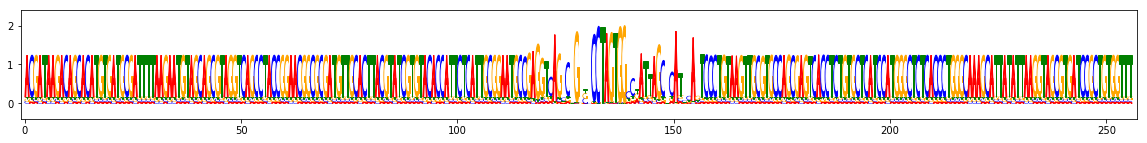

gradients


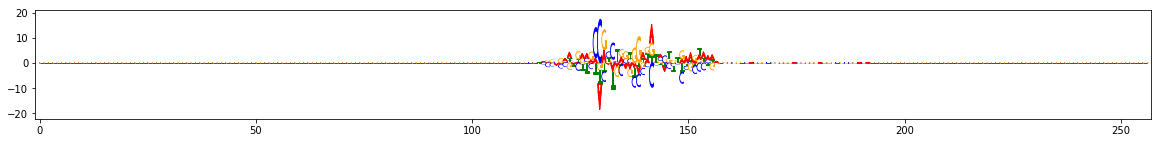

In [10]:
g = good_batch_gen(rand_batch_gen, iterate)

input_seqs = next(g)

# find an appropriate step size
activation, grads = iterate([input_seqs, 0])
max_grad = np.amax(grads)
step = (1/max_grad)*5

print(ctcfgen.decode(input_seqs[0]).tostring().decode('UTF-8'))
orig_seqs = input_seqs
checkpoint_seqs = orig_seqs
norm_seqs = orig_seqs
print('original sequence')
#viz_sequence.plot_icweights(input_seqs[0])

for i in range(10):
    activations, grads = iterate([input_seqs, 0])
    
    #check changes are still made
    if (0 < np.amax(input_seqs - checkpoint_seqs) < 0.0001) or (np.amax(grads) < 1/(step*10)):
        print('sequence after '+ str(i+1) + ' iterations')
        viz_sequence.plot_icweights(input_seqs[0])
        print('gradients')
        viz_sequence.plot_weights(grads[0])
        print('Nothing is happening')
        break
     
    
    #input_seqs = softmax((input_seqs+ input_seqs*grads*step)*3)
    # update the sequence 
    input_seqs = softmax((input_seqs+ input_seqs*grads*step)*3) # or *5?
    norm_seqs = softmax(norm_seqs*3)
    
    #print some stuff
    if i % 50 == 0:
        print('sequence after '+ str(i+1) + ' iterations')
        viz_sequence.plot_icweights(input_seqs[0])
        print('gradients')
        viz_sequence.plot_weights(grads[0])
        
output_seqs = input_seqs - norm_seqs

[130 121 125 131 133 103  90 125 118 162 100 114 129 135 120 129 102 120
 106 135 118 135 128 136 138 128 141 134 125 128 134 153]
[-2, 7, 3, -3, -5, 25, 38, 3, 10, -34, 28, 14, -1, -7, 8, -1, 26, 8, 22, -7, 10, -7, 0, -8, -10, 0, -13, -6, 3, 0, -6, -25]


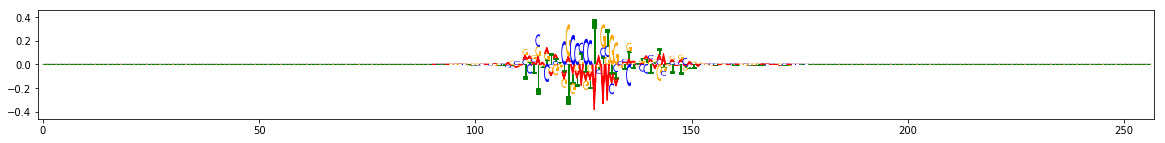

ValueError: math domain error

In [11]:
# align the seqences in the batch
activations, grads = iterate([input_seqs, 0])
peak_indicies = np.argmax(np.sum(grads, axis=-1), axis=1)
print(peak_indicies)
roll_indicies = [input_window//2-idx for idx in peak_indicies]
print(roll_indicies)
rolled_seqs = []
for idx, seq in zip(roll_indicies, output_seqs):
    rolled_seqs.append(np.roll(seq, idx, axis=0))
rolled_seqs = np.asarray(rolled_seqs)    
    
viz_sequence.plot_weights(output_seqs[2])
_ = viz_sequence.plot_icweights(rolled_seqs[2])

In [ ]:
preds = model.predict(rolled_seqs)
preds_conf = model.predict(input_seqs)
for seq, pred, pred_conf in zip(rolled_seqs, preds, preds_conf):
    viz_sequence.plot_icweights(seq[78:178])
    print('Prediction: ' + str(pred))
    print('Prediction2: ' + str(pred_conf))

In [ ]:
# what if we used differences as a measure of importance?
# 'good' bases will have the least change, 'bad' bases will have the largest positive change
pos_diffs = (input_seqs - orig_seqs).clip(min=0)
neg_diffs = (orig_seqs - input_seqs).clip(min=0)
overlay_seqs = softmax((input_seqs * orig_seqs)*4)
print('starting point:')
viz_sequence.plot_icweights(orig_seqs[4][78:178])
print('ideal sequence:')
viz_sequence.plot_icweights(input_seqs[4][78:178])
print('enriched in ideal:')
bad = viz_sequence.plot_icweights(pos_diffs[4][78:178])
print('enriched in original:')
viz_sequence.plot_icweights(neg_diffs[4][78:178])
print('found in both:')
good = viz_sequence.plot_icweights(overlay_seqs[4][78:178])
print('good-bad difference?')
viz_sequence.plot_weights(good-bad)

In [ ]:
def plot_activations(model, input_seqs, layer_name, all=True, viz=False, get_max=False, pre_max=None):
    seqs = model.input
    get_activations = K.function([seqs, K.learning_phase()], [layer_dict[layer_name].output, model.output])
    cmap = plt.get_cmap('plasma')
    def plot(ax, data, max_act):
        im = ax.imshow(data, interpolation='nearest',
                    cmap = cmap,
                    origin='lower',
                    aspect='auto', vmin=0, vmax = max_act)
        fig.colorbar(im, ax=ax)
        
    activations, predictions = get_activations([input_seqs, 0])
    print(activations.shape)
    
    if all:                
        for fact, ract, seq, pred in zip(activations[:32], activations[32:], input_seqs, predictions):
            if pre_max==None:
                max_act=max(np.amax(fact), np.amax(ract))
            else:
                max_act = pre_max
            fig, (ax1, ax2) = plt.subplots(ncols=2)
            ax1.set(title='Forward (' + str(pred[0]) + ')')
            plot(ax1, np.transpose(fact), max_act)

            ax2.set(title='Reverse ('  + str(pred[0]) +')')
            plot(ax2, np.transpose(np.flip(ract, axis=0)), max_act)
            plt.tight_layout()
            plt.show()
            if viz:
                viz_sequence.plot_icweights(seq)
            if get_max:
                return max_act
    else:
        if pre_max==None:
            max_act=max(np.amax(activations[0]), np.amax(activations[32]))
        else:
            max_act=pre_max
        fig, (ax1, ax2) = plt.subplots(ncols=2)
        ax1.set(title='Forward (' + str(predictions[0][0]) + ') ' + layer_name)
        plot(ax1, np.transpose(activations[0]), max_act)

        ax2.set(title='Reverse ('  + str(predictions[0][0]) +') '+ layer_name)
        plot(ax2, np.transpose(np.flip(activations[32], axis=0)), max_act)
        plt.tight_layout()
        plt.show()  
        if viz:
            viz_sequence.plot_icweights(input_seqs[0])
        if get_max:
                return max_act          

In [ ]:
plot_activations(model, input_seqs, 'conv1d_4', viz=True)

In [ ]:
# look at how chucks of dreamed sequences activate model
pre_max = plot_activations(model, input_seqs, 'conv1d_4', all=False, viz=True, get_max=True)
for i in range(len(input_seqs[0])//20 - 1):
    mutant_seqs = np.copy(input_seqs)
    mutant_seqs[0][20*i:20*(i+1)] = [[0, 0, 0, 0]]*20
    plot_activations(model, mutant_seqs, 'conv1d_4', all=False, viz=True, pre_max=pre_max)

In [ ]:
g = gen.pairgen(mode='test', batch_size=batch_size)
sample_seqs = next(g)[0]

plot_activations(model, sample_seqs, 'conv1d_1', all=False)
plot_activations(model, sample_seqs, 'conv1d_2', all=False)
plot_activations(model, sample_seqs, 'conv1d_3', all=False)
plot_activations(model, sample_seqs, 'conv1d_4', all=False)
plot_activations(model, sample_seqs, 'final_conv', all=False)

_ = viz_sequence.plot_icweights(sample_seqs[0])

In [ ]:
# look at how chucks of dreamed sequences activate model
pre_max = plot_activations(model, sample_seqs, 'conv1d_4', all=False, viz=True, get_max=True)
for i in range(len(sample_seqs[0])//20 - 1):
    mutant_seqs = np.copy(sample_seqs)
    mutant_seqs[0][20*i:20*(i+1)] = [[0, 0, 0, 0]]*20
    plot_activations(model, mutant_seqs, 'conv1d_4', all=False, viz=True, pre_max=pre_max)